# Synthetic time series with anomalies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from timeseries import SyntheticTS

## The `SyntheticTS` class

### Parameters

It takes three parameters for initialization.

- `start_time`: Start time in the format 'YYYY-MM-DD hh:mm:ss'
- `end_time`: End time in the format 'YYYY-MM-DD hh:mm:ss'
- `process_time_mins` : Time (in minutes) for a unit process e.g. 
    - mutual alignment of multiple machine parts
    - deposition of a chemical compound on a surface
    - a specific gas flow sequence (in a particular machine) in a semiconductor fab
    
### What is a _'process'_?

A simple illustration is shown below

![process-1](https://raw.githubusercontent.com/tirthajyoti/Synthetic-data-gen/master/images/Time-series-process-1.JPG)

In [115]:
class SyntheticTS:
    """
    Base synthetic timeseries class
    """

    def __init__(
        self,
        start_time="2021-01-01 00:00:00",
        end_time="2021-01-02 00:00:00",
        process_time_mins=10,
    ):
        """
        Initialize

        Args:
            start_time (str): Start time in the format 'YYYY-MM-DD hh:mm:ss'
            end_time (str): End time in the format 'YYYY-MM-DD hh:mm:ss'
            process_time_mins (float): Time (in minutes) for the unit process

        Returns: None
        """
        self.start_time = start_time
        self.end_time = end_time
        self.process_time = process_time_mins
        self._duration_ = np.datetime64(self.end_time) - np.datetime64(self.start_time)
        self._minutes_ = self._duration_ / np.timedelta64(1, "m")
        self._size_ = int(self._minutes_ / (self.process_time))
        self.time_arr = np.arange(
            self.start_time,
            self.end_time,
            step=self.process_time,
            dtype="datetime64[m]",
        )

        self._normal_flag_ = False
        self._anomaly_flag_ = False
        self._drifted_flag_ = False

    def __repr__(self):
        return "Customized synthetic time series class"

    def __str__(self):
        desc = (
            "Parameters\n"
            + "=" * 30
            + f"""\nStart time: {self.start_time}\nEnd time: {self.end_time} \nProcess time (minutes): {self.process_time}
        """
        )
        return desc

    def normal_process(
        self,
        loc=0.0,
        scale=1.0,
        return_df=True,
    ):
        """
        Initiates the normal process data

        Args:
            loc (float): Parameter (mean) for the underlying Gaussian distribution
            scale (float): Parameter (std.dev) for the underlying Gaussian distribution

        Returns:
            Pandas DataFrame: If `return_df=True` returns a dataframe with two columns -
            `time` with the datetime values, `normal_data` with the normal process data
            numpy.ndarray: If `return_df=False` returns just the array of normal process data
        """
        self.loc = loc
        self.scale = scale
        arr = np.random.normal(loc=self.loc, scale=self.scale, size=self._size_)
        self.normal_data = arr
        self._normal_flag_ = True
        if return_df:
            df = pd.DataFrame({"time": self.time_arr, "normal_data": self.normal_data})
            return df
        else:
            return self.normal_data

    def anomalize(
        self, anomaly_frac=0.02, anomaly_scale=1.0, one_sided=False, return_df=True
    ):
        """
        Induces anomalies in the normal process

        Args:
        anomaly_frac (float): Fraction of anomalies
        anomaly_scale (float): Scale factor of anomalies. The range of the normal data will be scaled by this factor to inject anomalies.
        Any positive number is accepted but a number > 1.0 is needed to create meaningful anomalies/outliers.
        one_sided (bool): Indicates whether the anomalies/outliers are one-sided in magnitude
        i.e. they are mostly higher in magnitude than the normal process data. Default=False
        i.e. outliers appear in both smaller and larger magnitude compared to the normal process data.

        Returns:
            Pandas DataFrame: If `return_df=True` returns a dataframe with two columns -
            `time` with the datetime values, `anomaly_data` with the anomalized data
            numpy.ndarray: If `return_df=False` returns just the array of the anomalized data
        """
        if not self._normal_flag_:
            print("Normal process is not initialized. Cannot anomalize")
            return None
        assert anomaly_frac > 0 and anomaly_frac < 1.0, print(
            "Anomaly fraction must be between 0.0 and 1.0"
        )
        assert anomaly_scale > 0, print(
            "Anomaly scale must be a number gerater than 0.0"
        )
        new_arr = self.normal_data.copy()
        arr_min = new_arr.min()
        arr_max = new_arr.max()
        no_anomalies = int(self._size_ * anomaly_frac)
        idx_list = np.random.choice(a=self._size_, size=no_anomalies, replace=False)
        for idx in idx_list:
            if one_sided:
                new_arr[idx] = self.loc + np.random.uniform(
                    low=arr_min, high=anomaly_scale * (arr_max - arr_min)
                )
            else:
                new_arr[idx] = self.loc + np.random.uniform(
                    low=-anomaly_scale * (arr_max - arr_min),
                    high=anomaly_scale * (arr_max - arr_min),
                )
        self.anomalized_data = new_arr
        self._anomaly_flag_ = True

        if return_df:
            df = pd.DataFrame(
                {"time": self.time_arr, "anomaly_data": self.anomalized_data}
            )
            return df
        else:
            return self.anomalized_data

    def _chunk(self, arr, num_chunk, chunk_size, ano_scale, one_sided):
        m = arr.mean()
        a_max = arr.max()
        a_min = arr.min()
        idx_chunks = []
        data_chunks = []
        idx_a = np.arange(len(arr))
        div = int(len(arr) / (num_chunk))
        for i in range(0, len(arr), div):
            idx_chunks.append(idx_a[i : i + div])
        for idx in idx_chunks[:-1]:
            tmpa = arr[idx]
            mid = int(len(tmpa) / 2)
            for j in range(mid - int(chunk_size / 2), mid + int(chunk_size / 2) + 1):
                if one_sided:
                    tmpa[j] = m + np.random.uniform(
                        low=a_min, high=ano_scale * (a_max - a_min)
                    )
                else:
                    tmpa[j] = m + np.random.uniform(
                        low=-ano_scale * (a_max - a_min),
                        high=ano_scale * (a_max - a_min),
                    )
            data_chunks.append(tmpa)
        a1 = np.array([])
        for d in data_chunks:
            a1 = np.append(a1, d)
        return a1

    def chunk_anomalize(
        self,
        num_chunks=2,
        anomaly_frac=0.02,
        anomaly_scale=1.0,
        one_sided=False,
        return_df=True,
    ):
        """
        Induces anomaly chunks in the normal process data

        Args:
        num_chunks (int): Number of chunked (grouped) anomalies
        anomaly_frac (float): Fraction of anomalies
        anomaly_scale (float): Scale factor of anomalies. The range of the normal data will be scaled by this factor to inject anomalies.
        Any positive number is accepted but a number > 1.0 is needed to create meaningful anomalies/outliers.
        one_sided (bool): Indicates whether the anomalies/outliers are one-sided in magnitude
        i.e. they are mostly higher in magnitude than the normal process data. Default=False
        i.e. outliers appear in both smaller and larger magnitude compared to the normal process data.

        Returns:
            Pandas DataFrame: If `return_df=True` returns a dataframe with two columns -
            `time` with the datetime values, `anomaly_data` with the anomalized data
            numpy.ndarray: If `return_df=False` returns just the array of the anomalized data
        """
        if not self._normal_flag_:
            print("Normal process is not initialized. Cannot anomalize")
            return None
        assert isinstance(num_chunks, int) and num_chunks > 0, print(
            "Number of chunks must be a positive integer"
        )
        assert anomaly_frac > 0 and anomaly_frac < 1.0, print(
            "Anomaly fraction must be between 0.0 and 1.0"
        )
        assert anomaly_scale > 0, print(
            "Anomaly scale must be a number gerater than 0.0"
        )
        no_anomalies = int(self._size_ * anomaly_frac)
        no_anomalies_chunk = int(no_anomalies / num_chunks)
        anomalies_last_chunk = no_anomalies - (no_anomalies_chunk * num_chunks)
        new_arr = self.normal_data.copy()
        new_arr = self._chunk(
            arr=new_arr,
            num_chunk=num_chunks,
            chunk_size=no_anomalies_chunk,
            ano_scale=anomaly_scale,
            one_sided=one_sided,
        )
        self.chunk_anomaly_data = new_arr
        self._anomaly_flag_ = True

        if return_df:
            df = pd.DataFrame(
                {"time": self.time_arr, "anomaly_data": self.chunk_anomaly_data}
            )
            return df
        else:
            return self.chunk_anomaly_data

    def drift(
        self, pct_drift_mean=20.0, pct_drift_spread=0.0, time_drift=None, return_df=True
    ):
        """
        Introduces data drift

        Args:
        pct_drift_mean (float): Percentage of mean drift.
        pct_drift_spread (float): Percentage change in the spread of the data.
        time_drift (str): The time at which drift starts in the format 'YYYY-MM-DD hh:mm:ss'.
        Will be converted and processed internally as a numpy.datetime64 object.

        Returns:
            Pandas DataFrame: If `return_df=True` returns a dataframe with two columns -
            `time` with the datetime values, `drifted_data` with the data after drift happens
            numpy.ndarray: If `return_df=False` returns just the array of the drifted data
        """

        self._pct_drift_mean_ = pct_drift_mean
        self._pct_drift_spread_ = pct_drift_spread
        if time_drift is None:
            drift_time = np.datetime64(self.end_time) - (self._duration_ / 2)
            self._drift_time_ = drift_time
        else:
            self._drift_time_ = np.datetime64(time_drift)

        self._duration_before_drift_ = self._drift_time_ - np.datetime64(
            self.start_time
        )
        self._drift_idx_ = int(
            self._duration_before_drift_
            / (np.timedelta64(1, "m") * (self.process_time))
        )
        self.before_drift_data = self.anomalized_data[: self._drift_idx_]
        self.after_drift_data = self.anomalized_data[self._drift_idx_ :]
        self.after_drift_data = self.after_drift_data + self.after_drift_data.mean() * (
            self._pct_drift_mean_ / 100
        ) * (1 + self._pct_drift_spread_ / 100)
        self.drifted_data = np.append(self.before_drift_data, self.after_drift_data)
        self._drifted_flag_ = True

        if return_df:
            df = pd.DataFrame(
                {"time": self.time_arr, "drifted_data": self.drifted_data}
            )
            return df
        else:
            return self.drifted_data

    def plot_normal(self):
        """
        Plots normal data
        """

        if not self._normal_flag_:
            print("Nothing initialized")
            return None
        else:
            plt.figure(figsize=(12, 4))
            plt.scatter(
                self.time_arr, self.normal_data, edgecolor="k", color="lightblue"
            )
            plt.show()

    def plot_anomaly(self):
        """
        Plots anomalized data
        """

        if not self._anomaly_flag_:
            print("Nothing anomalized")
            return None
        else:
            plt.figure(figsize=(12, 4))
            plt.scatter(
                self.time_arr, self.anomalized_data, edgecolor="k", color="lightblue"
            )
            plt.show()

    def plot_drifted(self):
        """
        Plots drifted data
        """

        if not self._drifted_flag_:
            print("Nothing drifted")
            return None
        else:
            plt.figure(figsize=(12, 4))
            plt.scatter(
                self.time_arr, self.drifted_data, edgecolor="k", color="lightblue"
            )
            plt.show()

## Example

- Start and end time of 1st May, 2021 and 6th May, 2021 respectively.
- Unit process time of 15 minutes

In [116]:
start_time = '2021-05-01 00:00:00'
end_time = '2021-05-06 06:00:00'
process_time_mins = 15

ts = SyntheticTS(start_time,end_time,process_time_mins)

### What is the object?

In [117]:
ts

Customized synthetic time series class

In [118]:
print(ts)

Parameters
Start time: 2021-05-01 00:00:00
End time: 2021-05-06 06:00:00 
Process time (minutes): 15
        


### Cannot plot w/o initiating the process

In [119]:
ts.plot_normal()

Nothing initialized


In [120]:
ts.plot_anomaly()

Nothing anomalized


### Normal process data

In [121]:
df=ts.normal_process(loc=100,scale=5)
df.head()

,time,normal_data
0,2021-05-01 00:00:00,103.710790
1,2021-05-01 00:15:00,101.162920
2,2021-05-01 00:30:00,102.189590
3,2021-05-01 00:45:00,100.317283
4,2021-05-01 01:00:00,96.892315


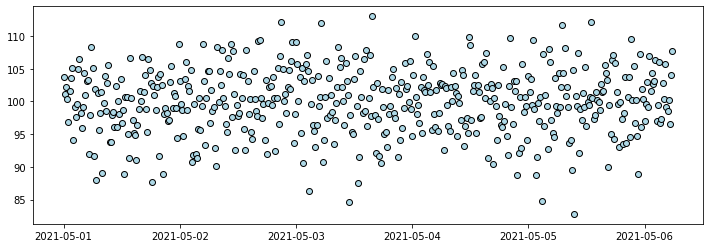

In [122]:
ts.plot_normal()

### Anomalize the data

In [123]:
df2 = ts.anomalize()
df2.head()

,time,anomaly_data
0,2021-05-01 00:00:00,103.710790
1,2021-05-01 00:15:00,101.162920
2,2021-05-01 00:30:00,102.189590
3,2021-05-01 00:45:00,100.317283
4,2021-05-01 01:00:00,96.892315


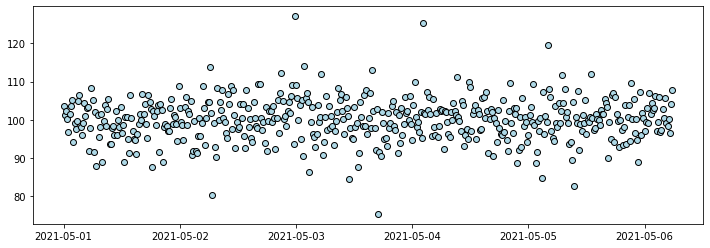

In [124]:
ts.plot_anomaly()

### One-sided anomaly

We set `one_sided=True` in the `anomalize` method.

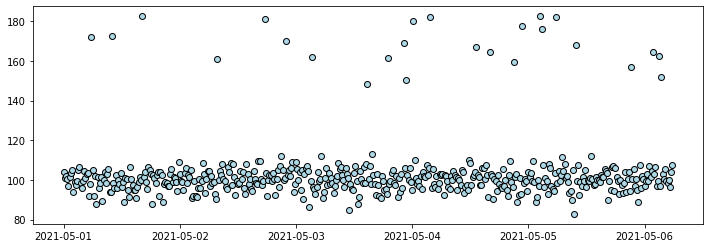

In [125]:
df2 = ts.anomalize(anomaly_frac=0.05,
                   anomaly_scale=1.5,
                   one_sided=True)
df2.head()
ts.plot_anomaly()

### Varying scales of anomaly

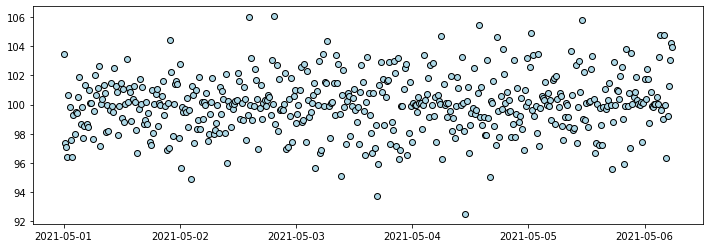

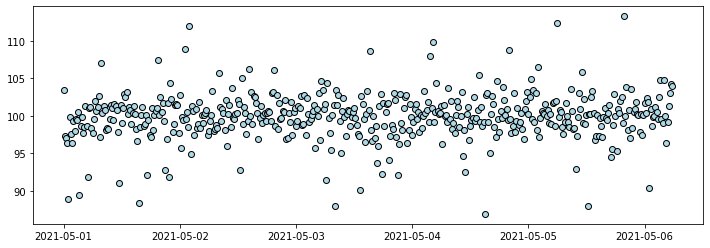

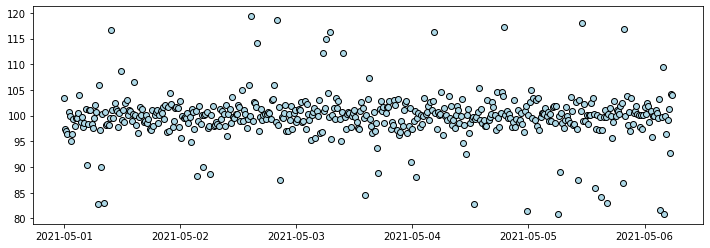

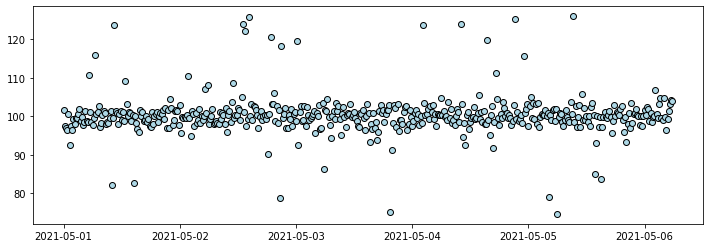

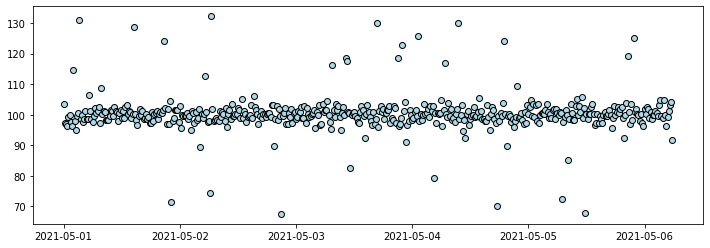

In [126]:
ts = SyntheticTS(start_time,end_time,process_time_mins)
_=ts.normal_process(loc=100,scale=2)
anomaly_scales = [0.01,1.0,1.5,2.0,2.5]
for a in anomaly_scales:
    ts.anomalize(anomaly_frac=0.1,anomaly_scale=a)
    ts.plot_anomaly()

### Varying fraction of anomalies (1% to 40%)

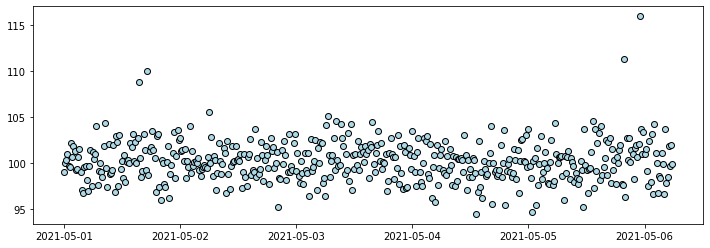

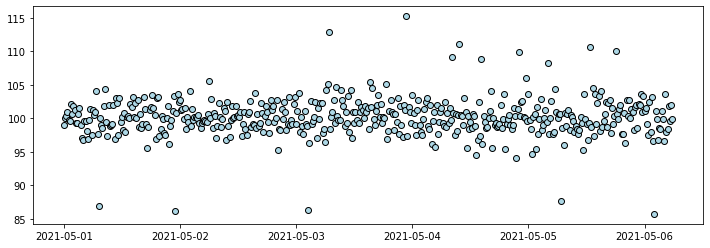

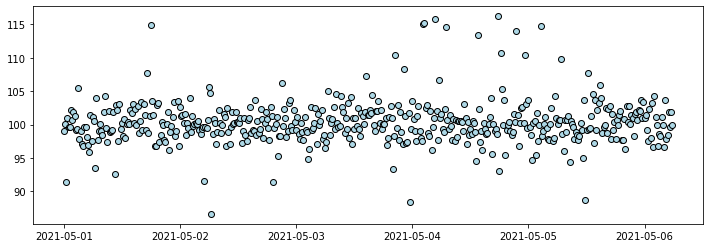

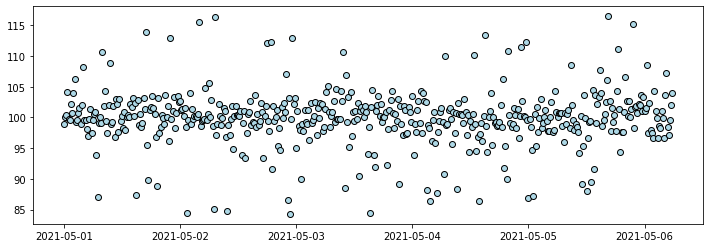

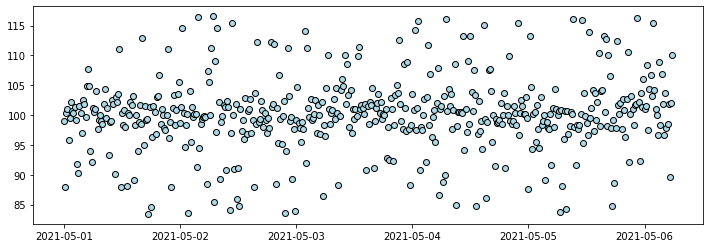

In [127]:
ts = SyntheticTS(start_time,end_time,process_time_mins)
_=ts.normal_process(loc=100,scale=2)
anomaly_fractions = [0.01,0.05,0.1,0.2,0.4]
for f in anomaly_fractions:
    ts.anomalize(anomaly_frac=f,anomaly_scale=1.5)
    ts.plot_anomaly()

### Introduce a positive drift
- No `time_drift` is mentioned. This will introduce the drift at the middle of the array i.e. at a time point which is exactly halfway between `start_time` and `end_time`

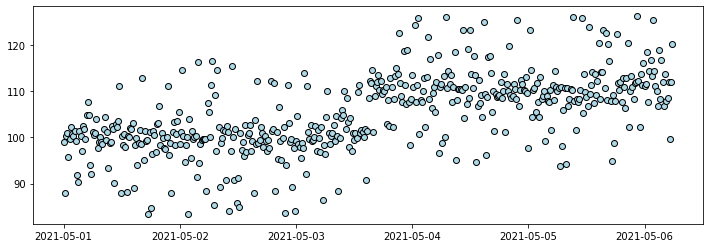

In [128]:
drifted=ts.drift(pct_drift_mean=10)
ts.plot_drifted()

### Negative drift at an arbitrary location
- `time_drift='2021-05-04 12:00:00'` is given with a negative mean drift

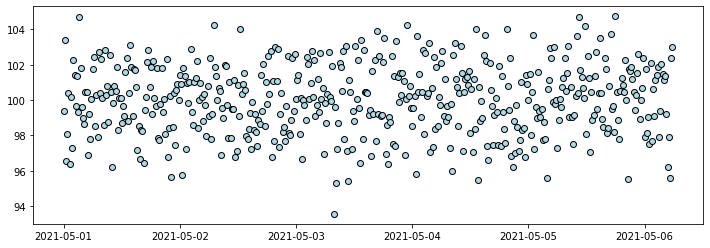

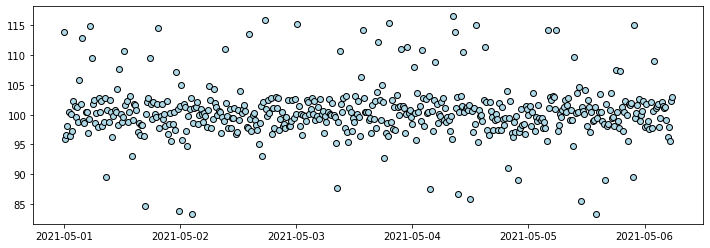

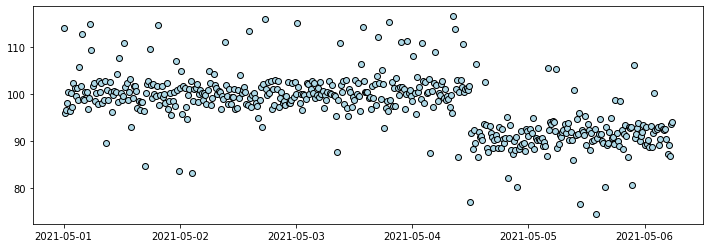

In [129]:
start_time = '2021-05-01 00:00:00'
end_time = '2021-05-06 06:00:00'
process_time_mins = 15
ts = SyntheticTS(start_time,end_time,process_time_mins)

df=ts.normal_process(loc=100,scale=2)
ts.plot_normal()
df2 = ts.anomalize(anomaly_frac=0.15,anomaly_scale=1.5)
ts.plot_anomaly()

drifted=ts.drift(pct_drift_mean=-8,
                 pct_drift_spread=10,
                time_drift='2021-05-04 12:00:00')
ts.plot_drifted()

### Chunked (group) of anomalies

Anomalies in 2 chunks


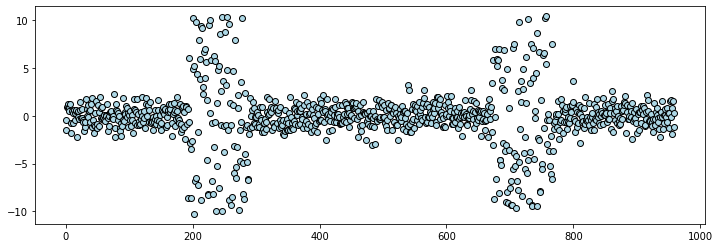

Anomalies in 3 chunks


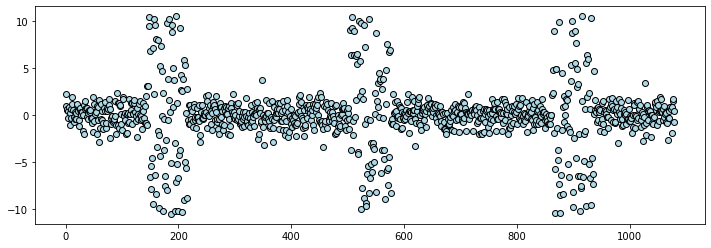

Anomalies in 4 chunks


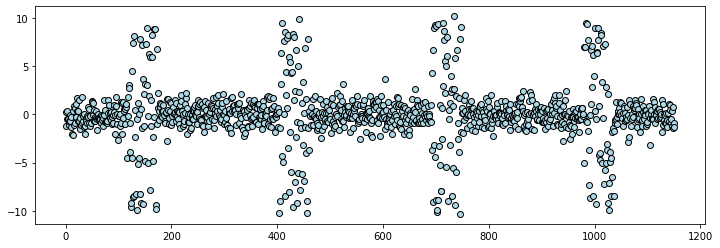

Anomalies in 5 chunks


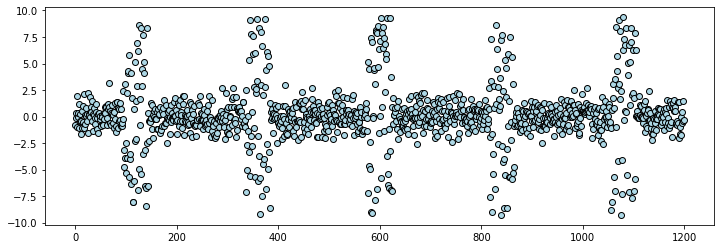

Anomalies in 6 chunks


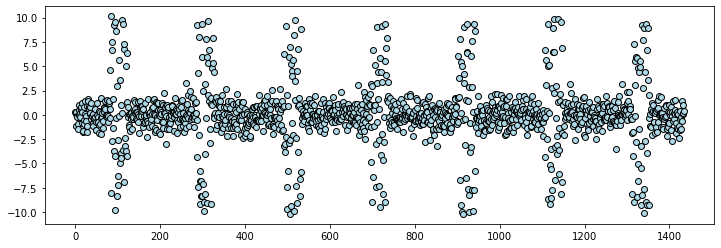

Anomalies in 7 chunks


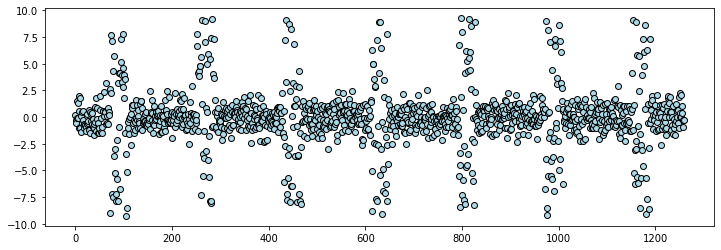

Anomalies in 8 chunks


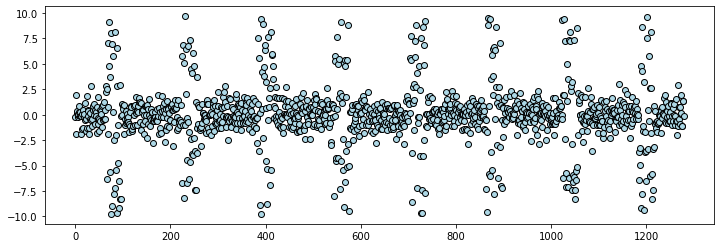

In [130]:
for i in range(3,10):
    print(f"Anomalies in {i-1} chunks")
    print("="*50)
    ts = SyntheticTS(process_time_mins=1)
    ts.normal_process()
    cd=ts.chunk_anomalize(anomaly_frac=0.2,num_chunks=i,anomaly_scale=1.5,return_df=False)
    plt.figure(figsize=(12, 4))
    plt.scatter(
                    np.arange(len(cd)), cd, edgecolor="k", color="lightblue"
                )
    plt.show()

### One-sided chunked anomalies

Anomalies in 2 chunks


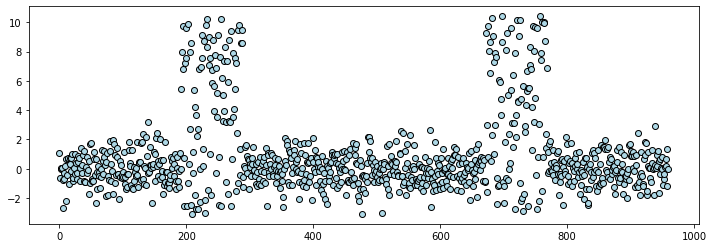

Anomalies in 3 chunks


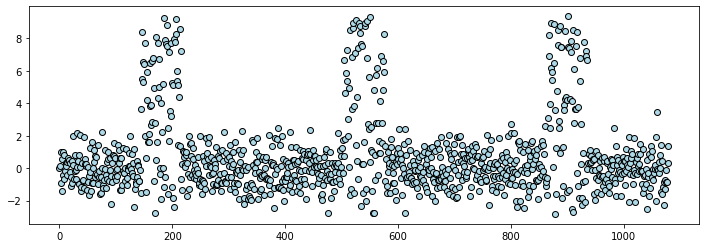

Anomalies in 4 chunks


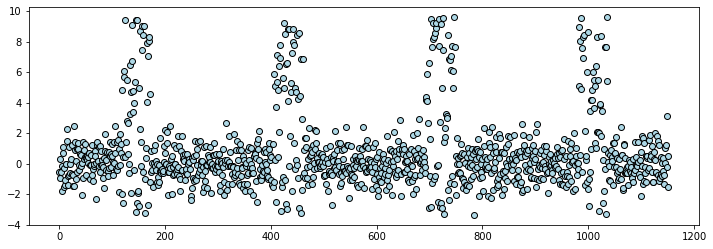

Anomalies in 5 chunks


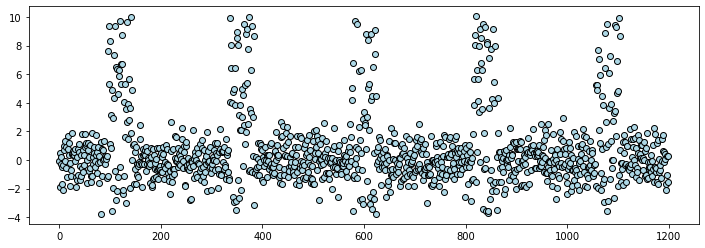

Anomalies in 6 chunks


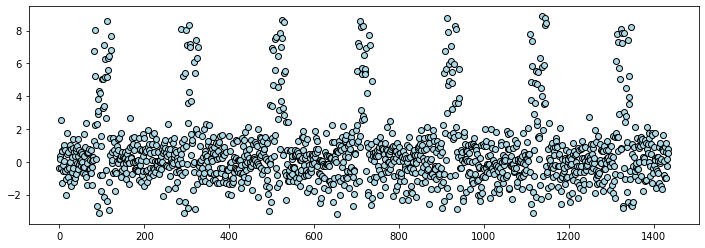

Anomalies in 7 chunks


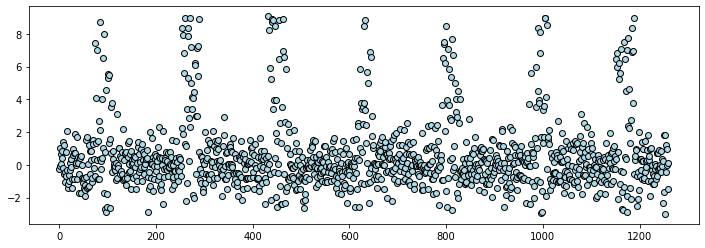

Anomalies in 8 chunks


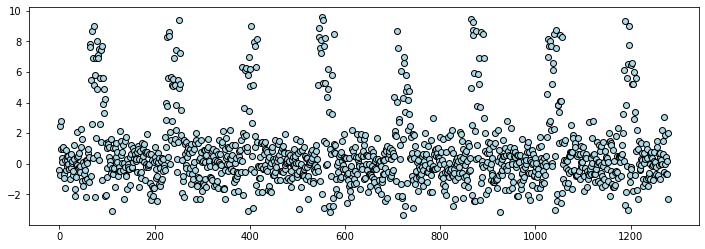

In [132]:
for i in range(3,10):
    print(f"Anomalies in {i-1} chunks")
    print("="*50)
    ts = SyntheticTS(process_time_mins=1)
    ts.normal_process()
    cd=ts.chunk_anomalize(anomaly_frac=0.2,num_chunks=i,
                          anomaly_scale=1.5,one_sided=True,return_df=False)
    plt.figure(figsize=(12, 4))
    plt.scatter(
                    np.arange(len(cd)), cd, edgecolor="k", color="lightblue"
                )
    plt.show()